In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from pyannote.core import Annotation,Segment, Timeline

In [5]:
import clustering

## Precompute embeddings

In [6]:
from pyannote.audio.keras_utils import load_model
from pyannote.audio.features import YaafeMFCC
from pyannote.audio.embedding.extraction import SequenceEmbedding

PRETRAINED_TRISTOUNET = '/people/yin/projects/pyannote-audio/tutorials/speaker-embedding/2+0.5/TristouNet/train/Etape.SpeakerDiarization.TV.train/weights/0986.h5'
model = load_model(PRETRAINED_TRISTOUNET)

feature_extraction = YaafeMFCC(duration=0.032, step=0.020, sample_rate=16000,
                               coefs=11, D=True, DD=True,
                               e=False, De=True, DDe=True)

duration, step = 2, 1
sequence_embedding = SequenceEmbedding(model, feature_extraction, 
                                       duration, step=step)


Using Theano backend.
/people/yin/anaconda3/envs/pyannote_35/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
from itertools import chain
from pyannote.database import get_protocol, get_unique_identifier
from pyannote.audio.embedding.extraction import SequenceEmbedding
from pyannote.database import FileFinder

protocol = get_protocol('Etape.SpeakerDiarization.TV', preprocessors={'audio': FileFinder()}, progress=True)
embeddings = {}
for current_file in chain(protocol.train(), protocol.development(), protocol.test()):
    embeddings[get_unique_identifier(current_file)] = sequence_embedding.apply(current_file)

Training set: 28it [01:05,  1.43s/it]
Development set: 9it [00:19,  1.90s/it]
Test set: 9it [00:19,  1.89s/it]


## Online clustering

In [8]:
from pyannote.audio.features import Precomputed

score_path = '/vol/work1/yin/speech_activity_detection/shallow/train/REPERE.SpeakerDiarization.All.train/tune/Etape.SpeakerDiarization.TV.development/apply/'
score_precomputed = Precomputed(score_path)

In [10]:
for current_file in protocol.development():
    onlineCluster = clustering.OnlineClustering(get_unique_identifier(current_file))
    annotation = current_file['annotation']
    timeline = annotation.get_timeline()
    embedding = embeddings[get_unique_identifier(current_file)]
    sad_score = score_precomputed(current_file)
    for segment in timeline:
        if np.mean(sad_score.crop(segment), axis=0)[1] < 0.5:
            continue
        data = {}
        data['embedding'] = embedding.crop(segment)
        data['segment'] = segment
        onlineCluster.upadateCluster(data)
    break

Development set: 0it [00:00, ?it/s]


In [11]:
onlineCluster.getLabels()

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

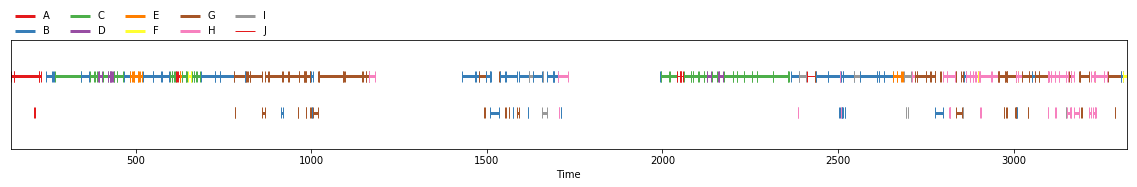

In [12]:
onlineCluster.getAnnotations()

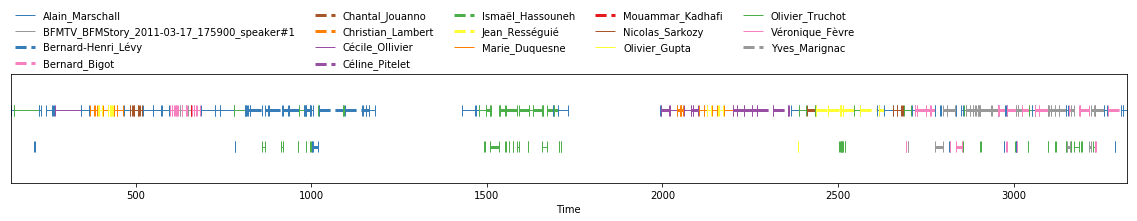

In [13]:
annotation